# Drug toxicity screening on human iPSC-derived cardiomyocites

## Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are frequently used drugs in cancer treatment. Unfortunately, cardiomyopathy may occur as a severe side effect of these drugs due to cardiotoxicity.   
  
Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Doxorubicin
- Gefinitib

## Objectives
1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.

In [29]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import gseapy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [30]:
counts = pd.read_csv(
    "Session_3_4/split_datasets/counts_msn05_group_1.txt", sep="\t", index_col=0
)
counts

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,EPI_1,EPI_2,EPI_3,EPI_4,GEF_1,GEF_2,GEF_3,GEF_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,147,63,65,201,43,54,54,97,43,66,25,123,14,31,39,57,36,61,85,58
MIR6859-1,24,9,0,5,11,6,6,12,4,5,2,13,4,2,11,13,4,6,10,2
MIR1302-2HG,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,107036,73372,45472,8313,28995,54639,40297,73551,32030,132198,62151,81016,24978,36829,41599,90494,52715,136864,29949,32612
TRNE,1,0,0,0,0,1,0,0,1,0,0,5,0,0,0,0,1,1,0,0
CYTB,337937,242836,146674,17113,110922,143736,120934,238506,89561,359665,148701,251132,77803,95509,235498,354974,126033,306581,117685,115165
TRNT,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [31]:
metadata_df = pd.read_csv(
    "Session_3_4/split_datasets/metadata_msn05_group_1.txt", sep="\t", index_col=0
)
metadata_df

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5
CTRL_6,Control,0nM,MSN05,cardiomyocytes,6
CTRL_7,Control,0nM,MSN05,cardiomyocytes,7
CTRL_8,Control,0nM,MSN05,cardiomyocytes,8
CTRL_9,Control,0nM,MSN05,cardiomyocytes,9
CTRL_10,Control,0nM,MSN05,cardiomyocytes,10


# PCA

In [32]:
total_reads = counts.sum(axis=0)
normalized_count_table = (counts / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [33]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

In [34]:
pca = PCA()

pca_result_matrix = pca.fit_transform(scaled_table)

In [35]:
np.shape(pca_result_matrix)

(20, 20)

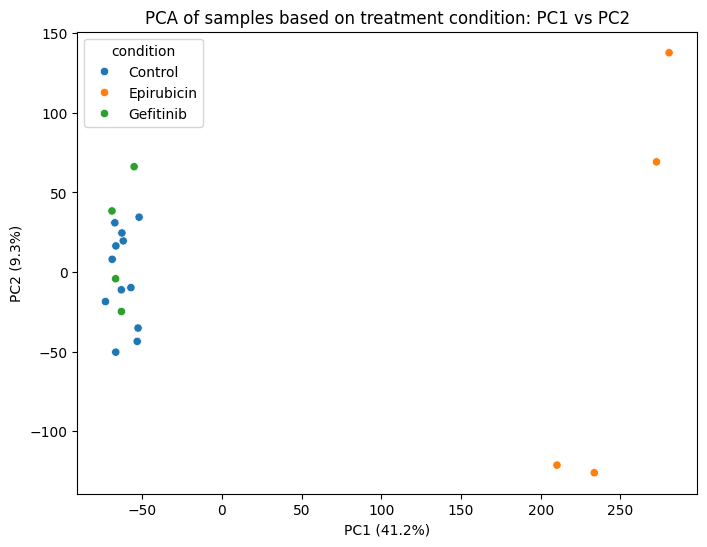

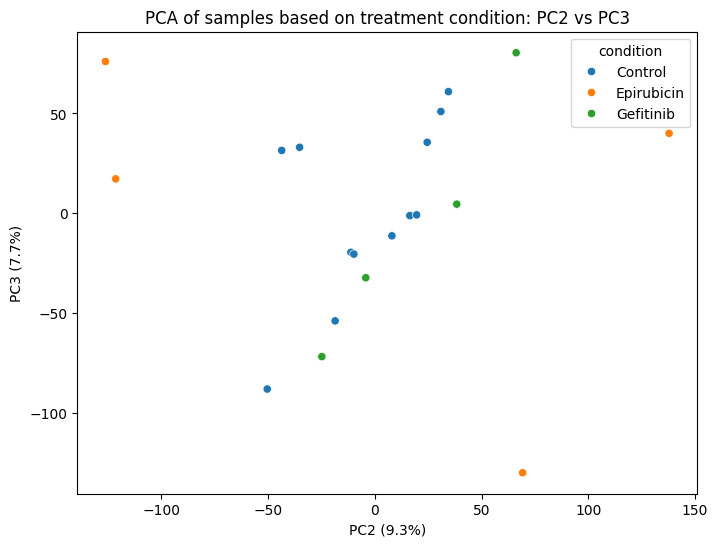

In [36]:
plot_df = pd.DataFrame(
    {
        "PC1": pca_result_matrix[:, 0],
        "PC2": pca_result_matrix[:, 1],
        "PC3": pca_result_matrix[:, 2],
        "condition": metadata_df["treatment"].values,
    }
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="condition")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC1 vs PC2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC2", y="PC3", hue="condition")
plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC2 vs PC3")
plt.show()

# DEseq2

## Epirubicin vs Control

In [37]:
drug = "Epirubicin"

metadata_df_filtered_epi = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_epi = counts[metadata_df_filtered_epi.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_epi.T,
    metadata=metadata_df_filtered_epi,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_epi = DeseqStats(deseq_object, contrast=("treatment", "Epirubicin", "Control"))
stat_res_epi.summary()
results_df_epi = stat_res_epi.results_df


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.87 seconds.

Fitting dispersion trend curve...
... done in 2.55 seconds.

Fitting MAP dispersions...
... done in 2.99 seconds.

Fitting LFCs...
... done in 3.52 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 81 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Epirubicin vs Control
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN           NaN   
WASH7P           57.697526       -0.239432  0.275426 -0.869314  3.846753e-01   
MIR6859-1         6.930263        0.759608  0.558735  1.359513  1.739842e-01   
MIR1302-2HG       0.213792        1.222496  3.695011  0.330850  7.407575e-01   
MIR1302-2         0.000000             NaN       NaN       NaN           NaN   
...                    ...             ...       ...       ...           ...   
ND6           55832.116528        0.506917  0.418967  1.209920  2.263094e-01   
TRNE              0.353499       -0.734975  3.042852 -0.241542  8.091354e-01   
CYTB         174637.330653        0.787430  0.412171  1.910444  5.607605e-02   
TRNT              0.257545        1.463016  3.711893  0.394143  6.934755e-01   
TRNP           3277.564796        3.461630  0.3550

... done in 3.05 seconds.



In [38]:
# Get upregulated and downregulated genes
upregulated_genes_epi = results_df_epi[
    (results_df_epi["log2FoldChange"] > 2) & (results_df_epi["padj"] < 0.05)
]
downregulated_genes_epi = results_df_epi[
    (results_df_epi["log2FoldChange"] < -2) & (results_df_epi["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_epi.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_epi.shape[0]}")

    Upregulated genes: 8165
    Downregulated genes: 961


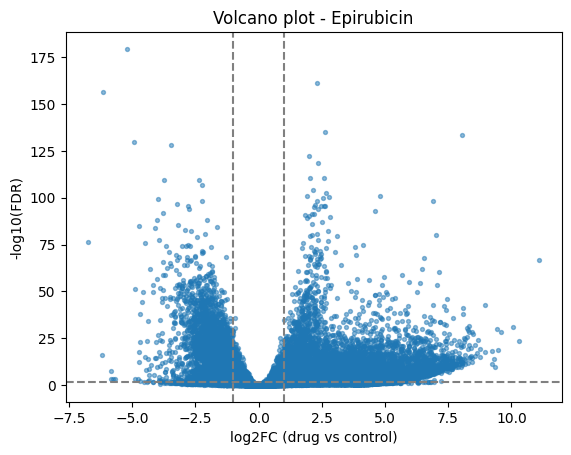

In [39]:
plt.scatter(
    results_df_epi.log2FoldChange, -np.log10(results_df_epi.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

## Gefinitib vs Control

In [40]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = counts[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.66 seconds.

Fitting dispersion trend curve...
... done in 1.67 seconds.

Fitting MAP dispersions...
... done in 2.31 seconds.

Fitting LFCs...
... done in 2.73 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Running Wald tests...
... done in 2.42 seconds.



Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           67.989688        0.209950  0.243883  0.860863  0.389314   
MIR6859-1         6.570236        0.087165  0.555795  0.156829  0.875380   
MIR1302-2HG       0.205009        0.774081  3.684159  0.210111  0.833581   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE              0.576040        0.264362  1.865684  0.141697  0.887319   
CYTB         173670.016579        0.382910  0.426741  0.897290  0.369564   
TRNT              0.066380        0.295672  3.849808  0.076802  0.938781   
TRNP           1076.775011        0.281788  0.349337  0.806636  0.419876   

                 p

In [41]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 11


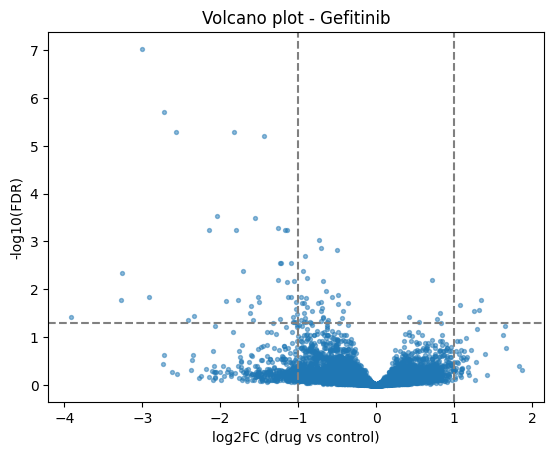

In [42]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

# GSEAPY

In [43]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

## Epirubicin vs Control

In [44]:
go_upr_results_epi = {}
go_dwr_results_epi = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_epi.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_epi[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_epi.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_epi[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025


    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


### Plot upregulated GO terms

In [45]:
for k, v in go_upr_results_epi.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

GO_Biological_Process_2025: (4414, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (353, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (909, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


### Plot downregulated GO terms

GO_Biological_Process_2025: (2612, 10)
GO_Cellular_Component_2025: (258, 10)
GO_Molecular_Function_2025: (519, 10)


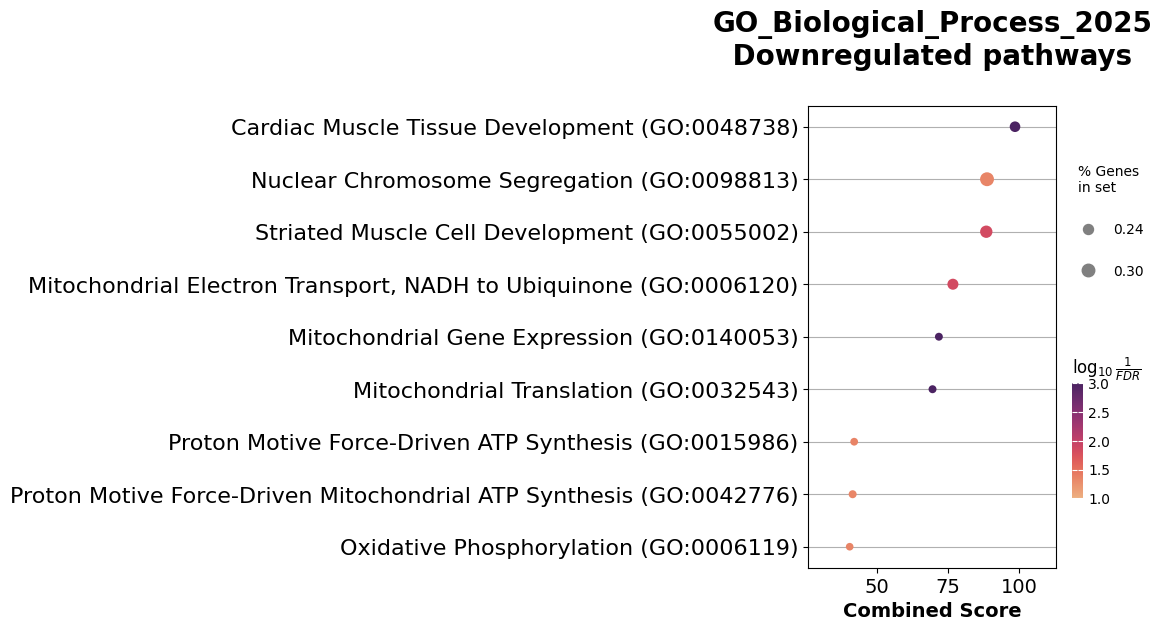

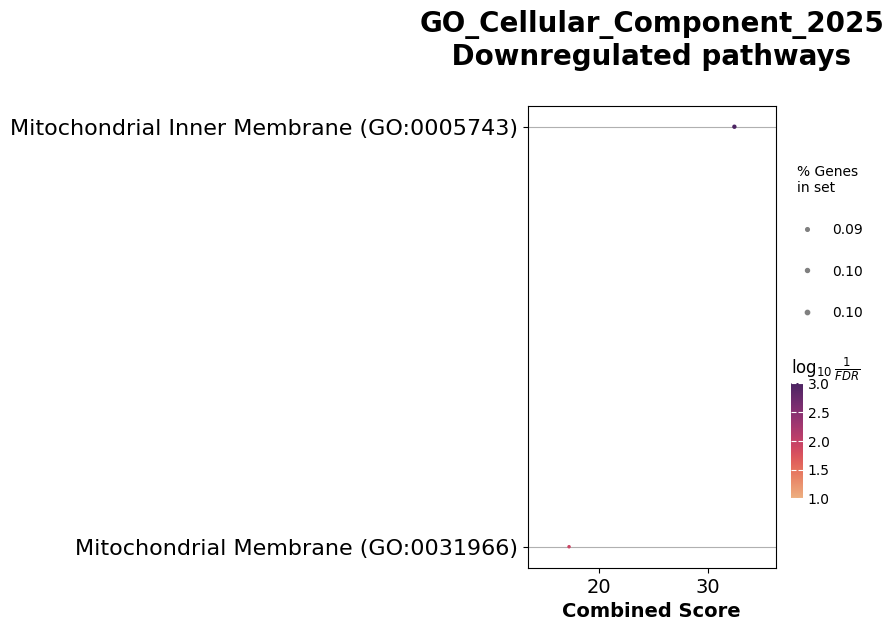

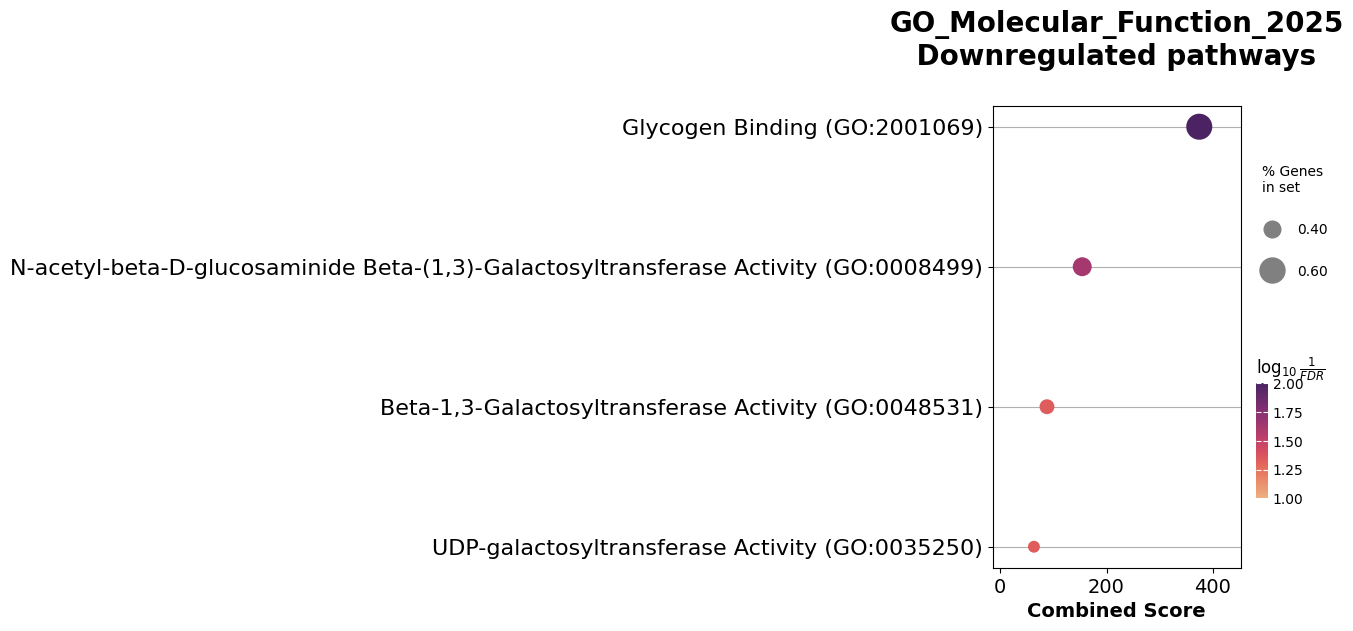

In [46]:
for k, v in go_dwr_results_epi.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

## Gefitinib vs Control

In [47]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [48]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [49]:
# --> no enriched pathways found

### Plot upregulated GO terms

In [50]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

### Plot downregulated GO terms

In [51]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")